# Evaluate Model Performance

This notebook demonstrates how to evaluate the performance of a sparse tensor decomposition model fit to simulated data by comparing the model components to the ground truth components used to generate the simulation. Model performance is evaluated on the basis of five metrics: 

1. Relative sum of squared errors (SSE)
    - Measures how closely the model matches the data
1. Factor match score (FMS)
    - Measures how closely two component matrices match one another
1. Precision
    - Proportion of test cluster membership that adheres to the ground truth
1. Recall
    - Proportion of ground truth membership recapitulated by test clusters
1. F1 score
    - Harmonic mean of precision and recall
    
SSE and FMS consider the model as a whole, whereas precision, recall, and F1 score deal with clusters derived from the factor matrices of a particular mode. In this case we derive clusters from mode-0, and determine cluster membership using the indices corresponding to non-zero weights. Note that the precision and recall metrics implemented in Barnacle are calculated according to the formula proposed by [Saelens et al. (2018)](https://www.nature.com/articles/s41467-018-03424-4), in order to accommodate overlapping clusters. For more on these metrics and their usage, see the article published alongside the Barnacle library. 


In [4]:
# imports

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import tensorly as tl
import tlviz
from barnacle import (
    SparseCP, 
    visualize_3d_tensor, 
    simulated_sparse_tensor, 
    pairs_precision_recall
)

# helper function to calculate f1 score from composite precision & recall scores
def composite_f1(precision, recall):
    '''
    Calculates F1 score from precision and recall.'''
    numerator = precision + recall
    if numerator == 0:
        return 0
    else:
        return (2 * precision * recall) / numerator


In [25]:
# generate simulated data

true_rank = 5
true_shape = [20, 15, 10]
true_densities = [.2, .4, .6]

# re-seed simulated data until all factor matrices are full rank
full_rank = False
while not full_rank:
    # generate simulated tensor
    sim_tensor = simulated_sparse_tensor(
        shape=true_shape,                
        rank=true_rank,                         
        densities=true_densities, 
        factor_dist_list=[
            scipy.stats.uniform(loc=-1, scale=2),  
            scipy.stats.uniform(),  
            scipy.stats.uniform()
        ], 
        random_state=9481
    )
    # check that all factors are full rank
    full_rank = np.all([np.linalg.matrix_rank(factor) == true_rank for factor in sim_tensor.factors])

# visualize noiseless simulated data tensor
fig = visualize_3d_tensor(
    sim_tensor.to_tensor(noise_level=0),
    shell=False, 
    midpoint=0, 
    show_colorbar=True,
    label_axes=True, 
    range_color=[-1, 1], 
    opacity=1, 
)
fig.show()


We'll fit a series of models to the simulated dataset, spanning a range of different numbers of components and sparsity coefficients. Then for each model, we evaluate it's performance in comparison to the simulated dataset. Note that the sum of squared errors (SSE) and factor match score (FMS) used in this evaluation are different than the SSE and FMS scores used in the [previous example on cross-validation](https://barnacle-py.readthedocs.io/en/latest/notebooks/cross-validation.html). In the previous example, cross-validated SSE was calculated by comparing the model to held out replicate data, and cross-validated FMS was calculated by comparing two models fit to different replicate datasets. 

In this case, we are evaluating all metrics in comparison to the simulation (a noiseless version of the simulated data tensor in the case of SSE, and the factors used to generate the simulation in the case of FMS, precision, recall, and F1). This type of experiment is only possible with simulated data, and allows us to ground-truth the effect of parameters on these different aspects of model performance.

In [36]:
# evaluate performance metrics on models fit with different parameters
# NOTE: this block of code takes a minute or two to run

# set parameters to explore
ranks = [1, 2, 3, 4, 5, 6, 7, 8]
lambdas = [0.01, 0.02, 0.1, 0.4, 1., 2.]
params = list(zip(ranks + [5 for l in lambdas], [0.2 for r in ranks] + lambdas))

# evaluate metrics for each set of parameters
results = []
for rank, lamb in params:
    print(f'Fitting models with rank={rank} and lambda={lamb}')
    # instantiate sparse cp model
    model = SparseCP(
        rank=rank, 
        lambdas=[lamb, 0, 0],
        nonneg_modes=[1, 2], 
        tol=1e-5, 
        random_state=21158, 
        n_initializations=5
    )
    # fit model to 10 replicates of independent noisy tensors
    for replicate in range(5):
        # create data tensor with 2:1 signal:noise ratio
        noisy_sim_tensor = sim_tensor.to_tensor(noise_level=.5, sparse_noise=True, random_state=replicate)
        # fit model to noisy simulated data tensor
        cp = model.fit_transform(noisy_sim_tensor, verbose=0)
        # calculate SSE in comparison to noiseless simulated data tensor
        sse = tlviz.model_evaluation.relative_sse(cp, sim_tensor.to_tensor(noise_level=0))
        # calculate FMS in comparison to factor matrices used to generate simulation
        fms = tlviz.factor_tools.factor_match_score(cp, sim_tensor)
        # extract clusters from model and simulation
        model_clusters = cp.get_clusters(mode=0, boolean=True)
        sim_clusters = sim_tensor.get_clusters(mode=0, boolean=True)
        # evaluate precision, recall, and f1 score
        precision, recall = pairs_precision_recall(sim_clusters, model_clusters)
        f1 = composite_f1(precision, recall)
        results.append({
            'Rank': rank, 
            'Sparsity Coefficient': lamb, 
            'Replicate': replicate, 
            'SSE': sse, 
            'FMS': fms, 
            'Precision': precision, 
            'Recall': recall, 
            'F1': f1
        })
# compile results into DataFrame
results_df = pd.DataFrame(results)
results_df


Fitting models with rank=1 and lambda=0.2
Fitting models with rank=2 and lambda=0.2
Fitting models with rank=3 and lambda=0.2
Fitting models with rank=4 and lambda=0.2
Fitting models with rank=5 and lambda=0.2
Fitting models with rank=6 and lambda=0.2
Fitting models with rank=7 and lambda=0.2
Fitting models with rank=8 and lambda=0.2
Fitting models with rank=5 and lambda=0.01
Fitting models with rank=5 and lambda=0.02
Fitting models with rank=5 and lambda=0.1
Fitting models with rank=5 and lambda=0.4
Fitting models with rank=5 and lambda=1.0
Fitting models with rank=5 and lambda=2.0


,Rank,Sparsity Coefficient,Replicate,SSE,FMS,Precision,Recall,F1
0,1,0.2,0,0.384472,0.870112,0.439394,0.852941,0.580000
1,1,0.2,1,0.397529,0.910833,0.439394,0.852941,0.580000
2,1,0.2,2,0.384020,0.848842,0.439394,0.852941,0.580000
3,1,0.2,3,0.390881,0.868323,0.436364,0.705882,0.539326
4,1,0.2,4,0.400358,0.869343,0.436364,0.705882,0.539326
...,...,...,...,...,...,...,...,...
65,5,2.0,0,0.506489,0.135875,1.000000,0.029412,0.057143
66,5,2.0,1,0.509646,0.147198,1.000000,0.029412,0.057143
67,5,2.0,2,0.485476,0.160329,1.000000,0.029412,0.057143
68,5,2.0,3,0.512247,0.136309,1.000000,0.029412,0.057143


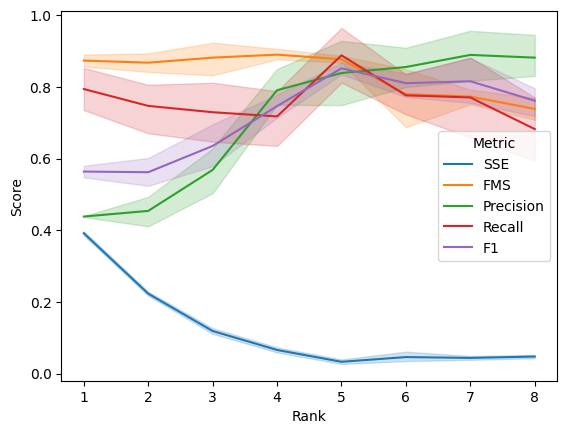

In [38]:
# look at effect of rank on model performance

# arrange data in tidy format for plotting
rank_plot_df = results_df[results_df['Sparsity Coefficient'] == 0.2].melt(
    id_vars=['Rank'], 
    value_vars=['SSE', 'FMS', 'Precision', 'Recall', 'F1'], 
    var_name='Metric', 
    value_name='Score'
)

# visualize cross-validation data
ax = sns.lineplot(
    rank_plot_df, 
    x='Rank', 
    y='Score',
    hue='Metric', 
)


There is a minimum in SSE that corresponds to the true number of components used to generate the simulation (rank=5). Recall and the F1 score peak at 5 components as well. FMS is mostly flat up to 5 components, after which it starts to drop off, and precision shows a steady increase with the number of components.

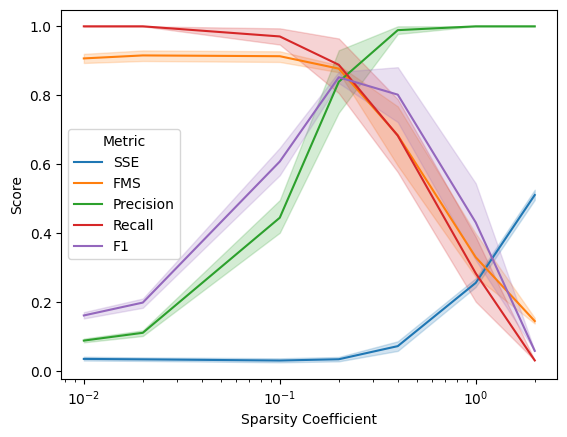

In [39]:
# look at effect of rank on model performance

# arrange data in tidy format for plotting
lambda_plot_df = results_df[results_df['Rank'] == 5].melt(
    id_vars=['Sparsity Coefficient'], 
    value_vars=['SSE', 'FMS', 'Precision', 'Recall', 'F1'], 
    var_name='Metric', 
    value_name='Score'
)

# visualize cross-validation data
ax = sns.lineplot(
    lambda_plot_df, 
    x='Sparsity Coefficient', 
    y='Score',
    hue='Metric', 
)
ax.set(xscale='log');


SSE is fairly flat up to a sparsity coefficient of 0.2, above which there is a steady increase in model error. Conversely, FMS is high up to a sparsity of coefficient of 0.2, above which it steady decreases. Precision and recall show inverse trends, with precision increasing with greater sparsity and recall decreasing with greater sparsity. The F1 score balances precision and recall in its quantification of cluster accuracy, and its peak coincides with the inflection points of SSE and FMS at a sparsity coefficient of 0.2.